# Урок 8. Снижение размерности данных

1. Обучить любую модель классификации на датасете IRIS до применения PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
def e_metrics(x1, x2):

    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [4]:
X, y = load_iris(return_X_y=True)


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)


k = 100

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на трейне при k = 100: 0.500
Точность алгоритма на тесте при k = 100: 0.467


In [5]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [6]:
# Для начала отмасштабируем выборку
X = X.astype(float)

X = standard_scale(X)

In [7]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X.T @ X

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.77467247979916, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021075, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.01353133569722, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.1072254642928883, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


In [8]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329986, 22.85076178670179, 3.66892188928287, 0.5178709107154814]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [9]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [10]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)

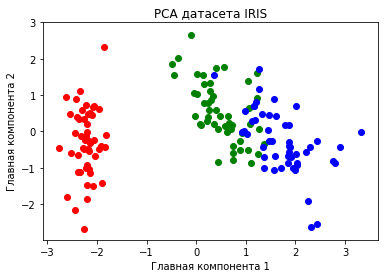

In [12]:
plt.figure()
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [13]:
Z_train, Z_test, y_z_train, y_z_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [14]:
y_z_pred_train = knn(Z_train, y_z_train, Z_train, k)
y_z_pred = knn(Z_train, y_z_train, Z_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_z_pred_train, y_z_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_z_pred, y_z_test):.3f}')

Точность алгоритма на трейне при k = 100: 0.675
Точность алгоритма на тесте при k = 100: 0.567


In [ ]:
Вывод: точность повысилась, так как изначально модель была переобучена, поэтому исключение части п